Step #1 Load the Time Series Data

In [5]:
import math # Mathematical functions 
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchsummary import summary
import logging
import matplotlib.pyplot as plt
import yfinance as yf
from matplotlib.pyplot import figure
import random
# Set random seed for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
from alpha_vantage.timeseries import TimeSeries

import seaborn as sns # Visualization
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
########################################################################################################################################################
config = {
    "alpha_vantage": {
        "key": "demo", # you can use the demo API key for this project, but please make sure to get your own API key at https://www.alphavantage.co/support/#api-key
        "symbol": "SPY",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
         "window_size": 20,
         "train_split_size": 0.90,
       
    }, 
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 64,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 32,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

def download_data(config):
    # Replace 'SPY' with the ticker symbol of the stock you want to fetch
        ticker_symbol = 'SPY'

    # Fetch historical data from Yahoo Finance
        df = yf.download(ticker_symbol, start='2010-01-01', end='2024-01-04')
    
    # Extract date in yyyy-mm-dd format
        df['Date'] = df.index.strftime('%Y-%m-%d')

    # Extract adjusted close price
        df['Adjusted_Close_Price'] = df['Adj Close']
    # Store the data in an Excel file
        df.to_excel('spy_data_lstm_yahoo.xlsx', index=False)

    # Read the data from the Excel file
        #df = pd.read_excel('spy_data_lstm_yahoo.xlsx')

    # Find the total number of data points
        num_data_points = len(df)
  
    # Find the date range (start and end dates)
        data_date = df['Date']
        data_close_price = df['Adjusted_Close_Price']
        volume = df['Volume']
        start_date = df['Date'].iloc[0]
        end_date = df['Date'].iloc[-1]
        display_date_range = f"{start_date} to {end_date}"
        print("Number data points", num_data_points, display_date_range)

        return data_date, data_close_price, num_data_points, display_date_range, volume, df

data_date, data_close_price, num_data_points, display_date_range, volume, df = download_data(config)

print("All libraries loaded")



[*********************100%%**********************]  1 of 1 completed
Number data points 3524 2010-01-04 to 2024-01-03
All libraries loaded


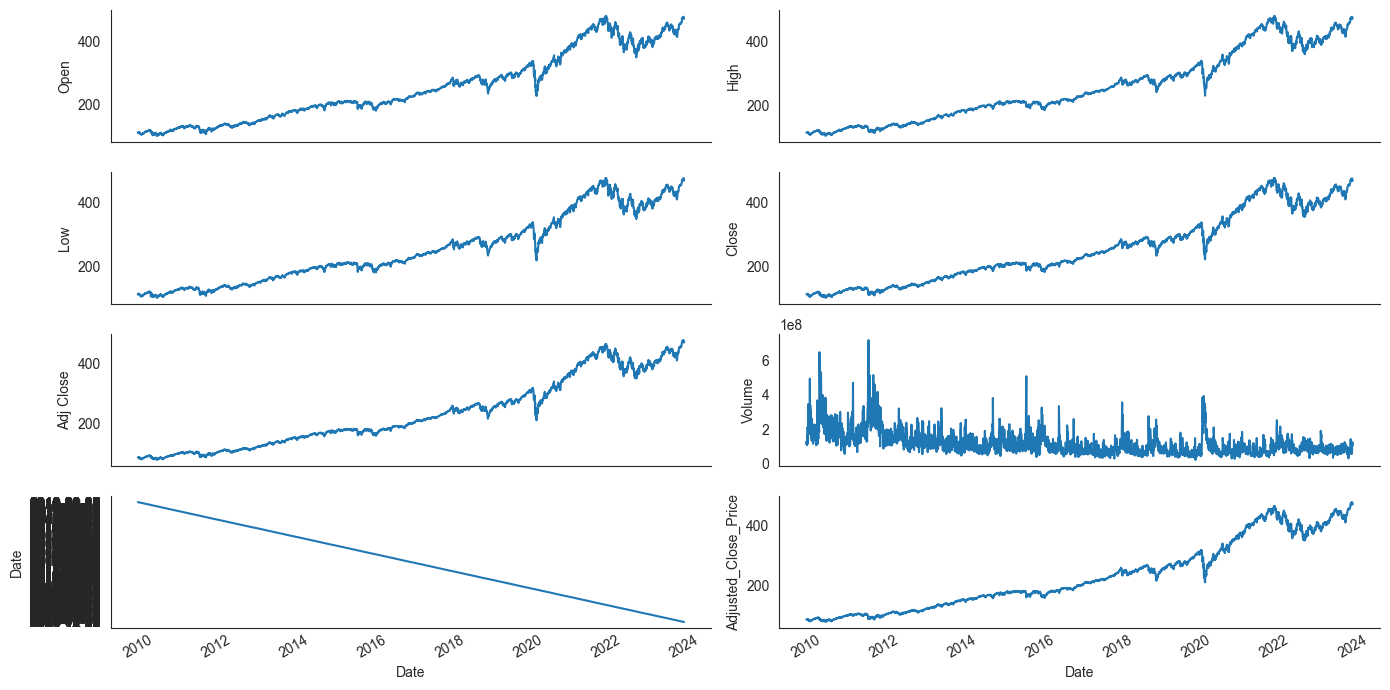

In [6]:
# Plot line charts
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

Step #3 Feature Selection and Scaling

In [ ]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

In [ ]:
'''
# plot

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, color=config["plots"]["color_actual"])
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.title("Daily close price for " + config["alpha_vantage"]["symbol"] + ", " + display_date_range)
plt.grid(which='major', axis='y', linestyle='--')
#plt.show()
'''
# Block-2::Data preparation: normalizing raw financial data
# normalize
class Normalizer():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0))
        self.sd = np.std(x, axis=(0))
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu

# Assuming data_close_price and data_volume are your two features
close_price_array = np.array([data_close_price])
data_volume = np.array([volume])

# Combine the two features into a single array
combined_data = np.concatenate((close_price_array, data_volume), axis=1)

scaler = Normalizer()
#normalized_data_close_price = scaler.fit_transform(data_close_price)
normalized_data_close_price = scaler.fit_transform(combined_data)


print("****************************************************")
print(normalized_data_close_price)
print("****************************************************")

def prepare_data_x(x, window_size):
    # perform windowing
    # Ensure that x is a NumPy array
    x = normalized_data_close_price.values
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
            
    return output[:-1], output[-1]


def prepare_data_y(x, window_size):
    # # perform simple moving average
    # output = np.convolve(x, np.ones(window_size), 'valid') / window_size
    # Ensure that x is a NumPy array
    x = normalized_data_close_price.values
    # use the next day as label
    output = x[window_size:]
    return output

data_x, data_x_unseen = prepare_data_x(normalized_data_close_price, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_data_close_price, window_size=config["data"]["window_size"])
print(len(data_x),len(data_y),len(data_x_unseen))
#print(normalized_data_close_price.head(21))
# split dataset

split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # in our case, we have only 1 feature, so we need to convert `x` into [batch, sequence, features] for LSTM
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

dataset_train = TimeSeriesDataset(data_x_train, data_y_train)
dataset_val = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", dataset_train.x.shape, dataset_train.y.shape)
print("Validation data shape", dataset_val.x.shape, dataset_val.y.shape)

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)

#Iterate Through Data Loaders:
print("Iterate Through Data Loaders:")
for batch_idx, (input_data, target_data) in enumerate(train_dataloader):
        print(f"Batch {batch_idx}: Input Shape: {input_data.shape}, Target Shape: {target_data.shape}")
        if batch_idx < 3:
            print(f"Batch {batch_idx}: Input Shape: {input_data.shape}, Target Shape: {target_data.shape}")

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=64, num_layers=2, output_size=1, dropout=0.1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]

def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=True)

#print(len(train_dataloader))
for batch in train_dataloader:
    # Process the batch
    x, y = batch
    #print(x.shape, y.shape)

val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=True)
print(len(val_dataloader))
for batch in val_dataloader:
    # Process the batch
    x, y = batch
    #print(x.shape, y.shape)

model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
model = model.to(config["training"]["device"])

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

for epoch in range(config["training"]["num_epoch"]):
    loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
    loss_val, lr_val = run_epoch(val_dataloader)
    scheduler.step()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))

# here we re-initialize dataloader so the data doesn't shuffled, so we can plot the values by date

train_dataloader = DataLoader(dataset_train, batch_size=config["training"]["batch_size"], shuffle=False)
val_dataloader = DataLoader(dataset_val, batch_size=config["training"]["batch_size"], shuffle=False)

model.eval()
# predict on the training data, to see how well the model managed to learn and memorize
predicted_train = np.array([])

for idx, (x, y) in enumerate(train_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_train = np.concatenate((predicted_train, out))

# predict on the validation data, to see how the model does

predicted_val = np.array([])

for idx, (x, y) in enumerate(val_dataloader):
    x = x.to(config["training"]["device"])
    out = model(x)
    out = out.cpu().detach().numpy()
    predicted_val = np.concatenate((predicted_val, out))

# prepare data for plotting
print("----plottings--------------")
to_plot_data_y_train_pred = np.zeros(num_data_points)
to_plot_data_y_val_pred = np.zeros(num_data_points)

to_plot_data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
to_plot_data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

to_plot_data_y_train_pred = np.where(to_plot_data_y_train_pred == 0, None, to_plot_data_y_train_pred)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

# plots

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(data_date, data_close_price, label="Actual prices", color=config["plots"]["color_actual"])
plt.plot(data_date, to_plot_data_y_train_pred, label="Predicted prices (train)", color=config["plots"]["color_pred_train"])
plt.plot(data_date, to_plot_data_y_val_pred, label="Predicted prices (validation)", color=config["plots"]["color_pred_val"])
plt.title("Compare predicted prices to actual prices")
xticks = [data_date[i] if ((i%config["plots"]["xticks_interval"]==0 and (num_data_points-i) > config["plots"]["xticks_interval"]) or i==num_data_points-1) else None for i in range(num_data_points)] # make x ticks nice
x = np.arange(0,len(xticks))
plt.xticks(x, xticks, rotation='vertical')
plt.grid(which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

# predict the closing price of the next trading day

model.eval()

x = torch.tensor(data_x_unseen).float().to(config["training"]["device"]).unsqueeze(0).unsqueeze(2) # this is the data type and shape required, [batch, sequence, feature]
prediction = model(x)
prediction = prediction.cpu().detach().numpy()

# prepare plots

plot_range = 10
to_plot_data_y_val = np.zeros(plot_range)
to_plot_data_y_val_pred = np.zeros(plot_range)
to_plot_data_y_test_pred = np.zeros(plot_range)

to_plot_data_y_val[:plot_range-1] = scaler.inverse_transform(data_y_val)[-plot_range+1:]
to_plot_data_y_val_pred[:plot_range-1] = scaler.inverse_transform(predicted_val)[-plot_range+1:]

to_plot_data_y_test_pred[plot_range-1] = scaler.inverse_transform(prediction)[0]
to_plot_data_y_val = np.where(to_plot_data_y_val == 0, None, to_plot_data_y_val)
to_plot_data_y_val_pred = np.where(to_plot_data_y_val_pred == 0, None, to_plot_data_y_val_pred)

to_plot_data_y_test_pred = np.where(to_plot_data_y_test_pred == 0, None, to_plot_data_y_test_pred)

# plot

plot_date_test = data_date[-plot_range+1:]
plot_date_test = pd.concat([plot_date_test, pd.Series(["tomorrow"])], ignore_index=True)

fig = figure(figsize=(25, 5), dpi=80)
fig.patch.set_facecolor((1.0, 1.0, 1.0))
plt.plot(plot_date_test, to_plot_data_y_val, label="Actual prices", marker=".", markersize=10, color=config["plots"]["color_actual"])
plt.plot(plot_date_test, to_plot_data_y_val_pred, label="Past predicted prices", marker=".", markersize=10, color=config["plots"]["color_pred_val"])
plt.plot(plot_date_test, to_plot_data_y_test_pred, label="Predicted price for next day", marker=".", markersize=20, color=config["plots"]["color_pred_test"])
plt.title("Predicted close price of the next trading day")
plt.grid(which='major', axis='y', linestyle='--')
plt.legend()
plt.show()

print("Predicted close price of the next trading day:", round(to_plot_data_y_test_pred[plot_range-1], 2))

# Prepare data for the DataFrame
data = {
    'date': data_date[config["data"]["window_size"] + split_index:],  # Adjust the starting index to align with the predictions
    'actual_close_price': scaler.inverse_transform(data_y_val),
    'predicted_price': scaler.inverse_transform(predicted_val),
}

# Create the DataFrame
df = pd.DataFrame(data)

# Calculate the difference between actual and predicted prices
df['difference'] = df['actual_close_price'] - df['predicted_price']
df['volume'] = volume

# Display the DataFrame
print(df.tail(5))
df.to_excel('spy_lstm_predictions.xlsx', index=False)